In [51]:
import ast
import re
import string

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from wordcloud import WordCloud

In [52]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## EDA and cleaning

In [53]:
with open(r"C:\Users\saras\Downloads\booksummaries.txt", encoding="utf8") as file:
    data = file.readlines()

### Convert the data to dataset

In [54]:
dataset = [line.split('\t') for line in data]
columns = ["id0", "id1", "name", "author", "publication year", "genres", "summary"]
df = pd.DataFrame(dataset, columns=columns)

In [55]:
df.head()

,id0,id1,name,author,publication year,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


### Drop unnecessary columns

In [56]:
df.drop(['id0', 'id1'], axis=1, inplace=True)

### Convert empty cells to NaN values

In [58]:
df.replace("", np.NaN, inplace=True)

### Extract the genre names

In [59]:
df['genres'] = df['genres'].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notna(x) else np.NaN)
df['genres'] = df['genres'].apply(lambda x: ", ".join(x) if isinstance(x, list) else np.NaN)

### Extract the publication year

In [60]:
df["publication year"] = df["publication year"].str[:4]

### Change data types of some columns

In [61]:
df.dtypes

name                object
author              object
publication year    object
genres              object
summary             object
dtype: object

In [62]:
df = df.astype({'publication year': pd.Int32Dtype()})

### Mpre information about the dataset

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              16559 non-null  object
 1   author            14177 non-null  object
 2   publication year  10949 non-null  Int32 
 3   genres            12841 non-null  object
 4   summary           16559 non-null  object
dtypes: Int32(1), object(4)
memory usage: 598.4+ KB


In [64]:
df.isnull().sum()

name                   0
author              2382
publication year    5610
genres              3718
summary                0
dtype: int64

In [65]:
df.duplicated().sum()

0

In [66]:
df.describe(include="all")

,name,author,publication year,genres,summary
count,16559,14177,10949.000000,12841,16559
unique,16277,4714,NaN,2154,16532
top,Nemesis,Agatha Christie,NaN,Novel,~Plot outline description~ --> <!--\n
freq,6,74,NaN,839,13
mean,NaN,NaN,1975.924194,NaN,NaN
std,NaN,NaN,49.641921,NaN,NaN
min,NaN,NaN,398.000000,NaN,NaN
25%,NaN,NaN,1966.000000,NaN,NaN
50%,NaN,NaN,1991.000000,NaN,NaN
75%,NaN,NaN,2003.000000,NaN,NaN


In [67]:
df["publication year"].describe()

count    10949.000000
mean      1975.924194
std         49.641921
min        398.000000
25%       1966.000000
50%       1991.000000
75%       2003.000000
max       2013.000000
Name: publication year, dtype: float64

In [68]:
df.head()

,name,author,publication year,genres,summary
0,Animal Farm,George Orwell,1945,"Roman à clef, Satire, Children's literature, S...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,1962,"Science Fiction, Novella, Speculative fiction,...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,1947,"Existentialism, Fiction, Absurdist fiction, Novel",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,<NA>,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,<NA>,"Hard science fiction, Science Fiction, Specula...",The novel posits that space around the Milky ...


### Distribution of publication year

<AxesSubplot:xlabel='publication year'>

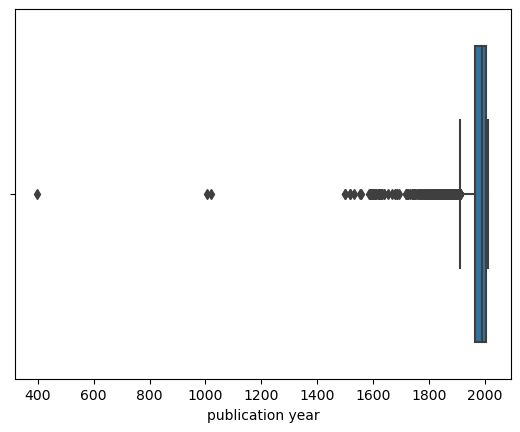

In [69]:
filtered_df = df[df["publication year"].notna()]["publication year"]
sns.boxplot(x=filtered_df)

In [70]:
df.loc[df["publication year"] < 1400]

,name,author,publication year,genres,summary
408,The Tale of Genji,Murasaki Shikibu,1021,Fiction,The work recounts the life of a son of the Ja...
1381,The Confessions of St. Augustine,Augustine of Hippo,398,Non-fiction,The work outlines Augustine's sinful youth an...
11333,The Wizard of London,Mercedes Lackey,1005,"Speculative fiction, Fantasy",As an acting prequel to the Elemental Masters...


### The oldest book in the dataset

In [71]:
df.loc[df["publication year"] == min(filtered_df)]

,name,author,publication year,genres,summary
1381,The Confessions of St. Augustine,Augustine of Hippo,398,Non-fiction,The work outlines Augustine's sinful youth an...


### Book count per genre plot

Text(0, 0.5, 'Genre')

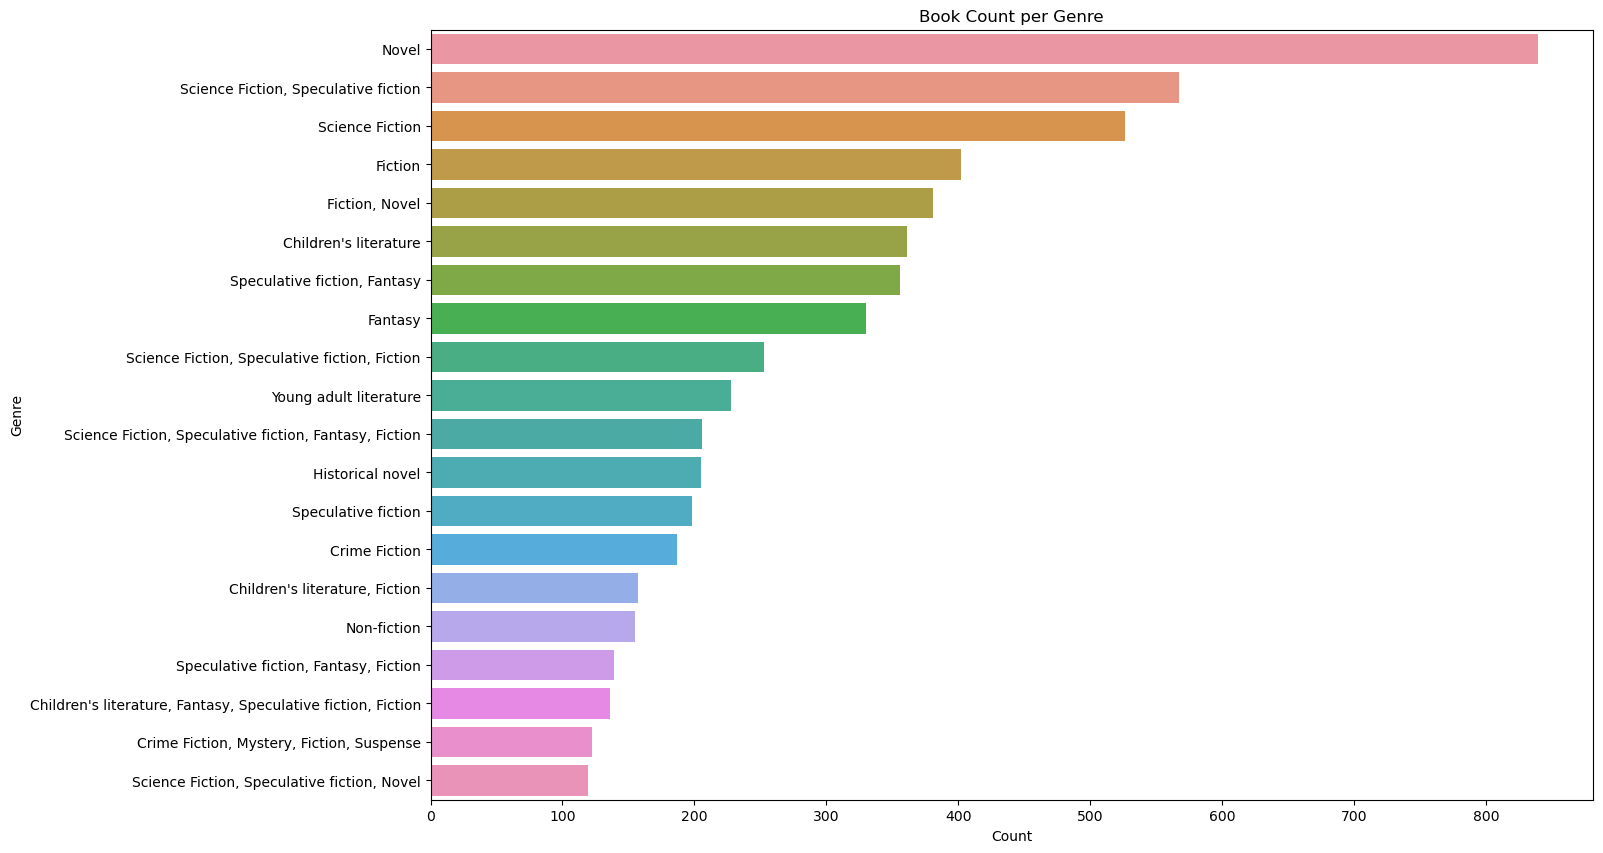

In [21]:
genre_counts = df['genres'].value_counts().reset_index().head(20)
genre_counts.columns = ['genres', 'count']
plt.figure(figsize=(15,10)) 
sns.barplot(data=genre_counts, x='count', y='genres')
plt.title('Book Count per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')

### Book count per author plot

Text(0, 0.5, 'Author')

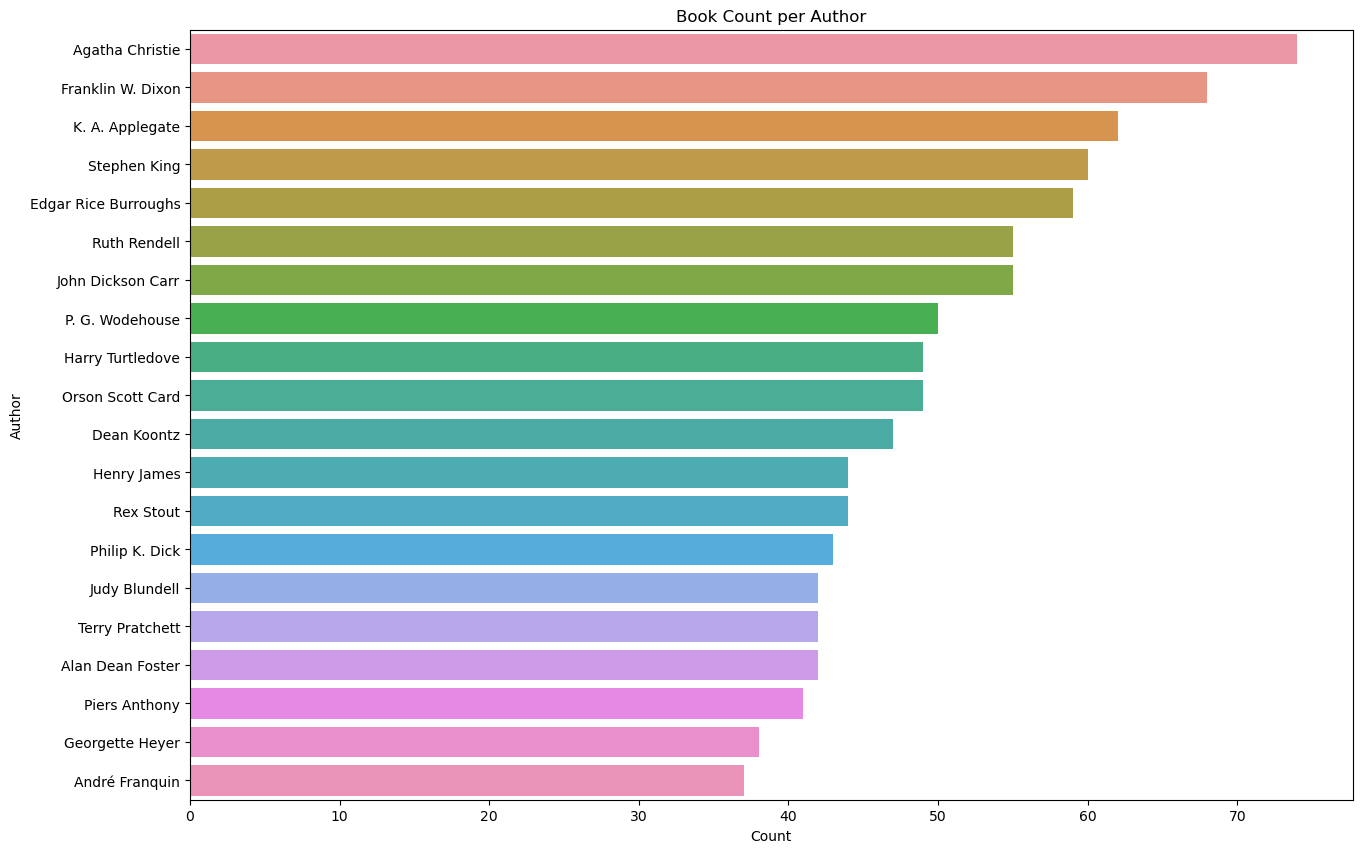

In [22]:
author_counts = df['author'].value_counts().reset_index().head(20)
author_counts.columns = ['authors', 'count']
plt.figure(figsize=(15,10)) 
sns.barplot(data=author_counts, x='count', y='authors')
plt.title('Book Count per Author')
plt.xlabel('Count')
plt.ylabel('Author')

### Word cloud for different genres

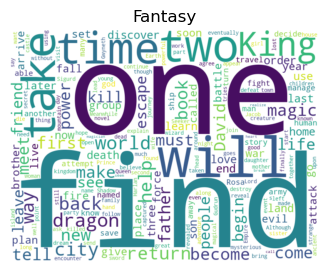

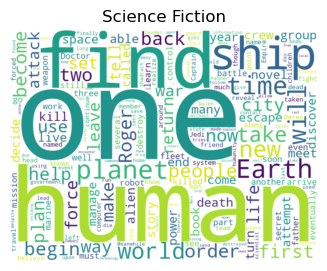

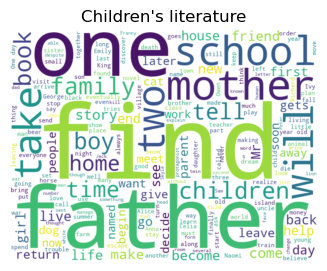

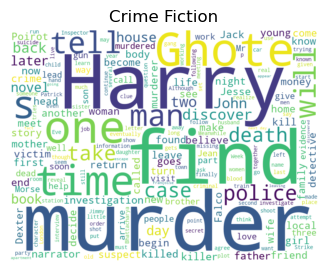

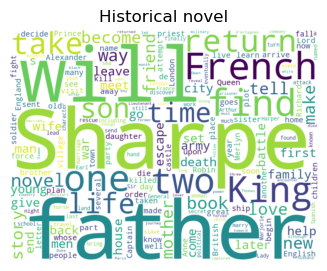

In [23]:
for genre in ["Fantasy", "Science Fiction", "Children's literature", "Crime Fiction", "Historical novel"]:    
    text = ' '.join(df.loc[df["genres"]==genre]["summary"])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(genre)
    plt.show()

## Conclusion from the EDA on Text Data:
### Popular Book and Author: "Nemesis" appears to be the most repeated book name, suggesting it might be a popular or significant work within the dataset. Agatha Christie stands out as the author with the most published books, indicating her prolific contribution to the dataset.
### Publishing Trends: The majority of the books in the dataset were published in 2007, indicating a potential peak in publishing activity during that year. This could be due to various factors such as literary trends, market demands, or specific events in the publishing industry.
### Historical Context: The dataset contains a wide range of publication dates, with the oldest book being "The Confessions of St. Augustine" by Augustine of Hippo, dating back to 398. This suggests diversity in the temporal origins of the texts, potentially spanning centuries.
### Genre Preferences: The most repeated genre is the novel, highlighting its popularity or prevalence within the dataset. This could indicate that novels constitute a significant portion of the texts under analysis, reflecting broader reading preferences or publishing trends.
### Common Themes: The analysis of summaries reveals that words like "find" and "one" are among the most repeated. This may suggest common themes across the texts, such as quests, discoveries, or singular narratives.
### Character Analysis: Within the crime fiction genre, the name "Harry" emerges as one of the most repeated. This could indicate the prominence of a recurring character or archetype named Harry within the genre, potentially offering insights into character preferences or narrative conventions.

### Handle missing publication years using mode

In [24]:
df["publication year"].fillna(df["publication year"].mode()[0], inplace=True)

### Text preprocessing functions

In [25]:
def lower_case(text):
    return text.lower()

In [26]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [27]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [28]:
def remove_whitespace(text):
    return " ".join(text.split())

In [29]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [30]:
def tokenization(text):
    return word_tokenize(text)

In [31]:
def stemming(text):
    singles = [stemmer.stem(word) for word in text]
    return singles

In [32]:
def lemmatizing(text):
    lemm_text = [lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [33]:
def clean_summary(summary):
    summary = lower_case(summary)
    summary = remove_numbers(summary)
    summary = remove_punctuation(summary)
    summary = remove_whitespace(summary)
    summary = remove_stopwords(summary)
    summary = tokenization(summary)
    summary = stemming(summary)
    return ' '.join(summary)

In [34]:
df_temp = df.copy()
df_temp["summary"] = df_temp["summary"].apply(lambda x: clean_summary(x))

### Generate a model for book genre prediction

In [35]:
# Filter dataframe to learn the model for genres
classified_summary_with_genre = df_temp[df_temp["genres"].notna()][["genres", "summary"]]

# Prepare data
x = classified_summary_with_genre["summary"]
y = classified_summary_with_genre["genres"] 

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True)
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

In [319]:
# Train Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

# Evaluate Naive Bayes classifier
predictions = nb_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
"Naive Bayes Accuracy: ", accuracy

0.09964966913195795

In [320]:
# Train Logistic Regression classifier
lr = LogisticRegression()
lr_clf = OneVsRestClassifier(lr)
lr_clf.fit(X_train_tfidf, y_train)

# Evaluate Logistic Regression classifier
predictions = lr_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
"Logistic Regression Accuracy", accuracy

0.17983651226158037

In [44]:
# Train SVM classifier
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train_tfidf, y_train)

# # Evaluate SVM classifier
predictions = svm_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
"SVM Accuracy", accuracy

('SVM Accuracy', 0.2143864598025388)

### Use SVM classifier to predict missing genres

In [37]:
for i in range(len(df_temp)):
    if pd.isnull(df_temp.loc[i, 'genres']):
        summary_vector = vectorizer.transform([df_temp.loc[i, 'summary']])
        predicted_genre = svm_clf.predict(summary_vector)
        df.loc[i, 'genres'] = predicted_genre

### Generate a model for author prediction

In [47]:
# Filter dataframe to learn the model
classified_summary_with_author = df_temp[df_temp["author"].notna()][["author", "summary"]]

# Prepare data
x = classified_summary_with_author["summary"]
y = classified_summary_with_author["author"] 

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True) 
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

In [325]:
# Train Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

# Evaluate Naive Bayes classifier
predictions = nb_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
"Naive Bayes Accuracy: ", accuracy

0.07581100141043723

In [326]:
# Train Logistic Regression classifier
lr = LogisticRegression()
lr_clf = OneVsRestClassifier(lr)
lr_clf.fit(X_train_tfidf, y_train)

# Evaluate Logistic Regression classifier
predictions = lr_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
"Logistic Regression Accuracy", accuracy

0.14844851904090267

In [48]:
# Train SVM classifier
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train_tfidf, y_train)

# Evaluate SVM classifier
predictions = svm_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
"SVM Accuracy", accuracy

0.2143864598025388

### Use SVM classifier to predict missing authors

In [49]:
for i in range(len(df_temp)):
    if pd.isnull(df_temp.loc[i, 'author']):
        summary_vector = vectorizer.transform([df_temp.loc[i, 'summary']])
        predicted_author = svm_clf.predict(summary_vector)
        df.loc[i, 'author'] = predicted_author

### Generate a summary of the given text using a simple frequency-based approach

In [ ]:
def summarizer(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Create frequency table for words
    freq_table = {word.lower(): freq_table.get(word.lower(), 0) + 1 for word in words if word.lower() not in set(stopwords.words('english'))}
    
    # Tokenize text into sentences
    sentences = sent_tokenize(text)
    
    # Create score for each sentence
    sentence_value = {sentence: sum(freq_table[word.lower()] for word in word_tokenize(sentence) if word.lower() in freq_table) for sentence in sentences}
    
    # Calculate average value of a sentence from the original text
    average = sum(sentence_value.values()) / len(sentence_value)
    
    # Generate summary based on the score of each sentence
    summary = ''
    coef = 1.2        
    while not summary and coef >= 1:
        summary = ' '.join(sentence for sentence in sentences if sentence_value.get(sentence, 0) > coef * average)
        coef -= 0.01
    
    return summary


### Condense the book summaries

In [ ]:
df_output = df[["name","summary"]]

In [19]:
df_output["condensed summaries"] = df_output["summary"].apply(lambda x: summarizer(x))

In [22]:
df_output.head()

,name,summary,condensed summaries
0,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...","Benjamin, the cynical donkey, who ""could read..."
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",Characterized as a sociopath and a hardened j...
2,The Plague,The text of The Plague is divided into five p...,"Towards the end of October, Castel's new anti..."
3,An Enquiry Concerning Human Understanding,The argument of the Enquiry proceeds by a ser...,(Hume 1974:356-359) Having dispensed with the...
4,A Fire Upon the Deep,The novel posits that space around the Milky ...,"The expedition's facility, called High Lab, i..."


In [ ]:
def image_generation(text):
    pipeline = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
    pipeline = pipeline.to('cuda')
    image = pipeline(prompt=text).images[0]
    return image

In [ ]:
df_output["images"] = df_output["condensed summaries"].apply(lambda x: image_generation(x))